## Lecture 9 - Curve Fitting (Chapter 11 in McClarren)

We just finished looking at interpolation, where the function we established goes right through all the data points.  Sometimes it is better not to insist on this constraint. Suppose we did an experiment and we expected the measured value to be linear in some variable $x$:

$$ f(x) = a + b x + \varepsilon $$

where $\varepsilon$ is an error term that contains the measurement error and inherent variability in the system.  So really, what we want is to find the values of $a$ and $b$ that best match our measured data, but not necessarily *exactly* match the data.

Another reason - maybe there is a hidden variable we do not know about, but we want the best possible model given the variables we DO know about.  Example:  radiation dose rate outside of a shield with an unknown source variability:

$$ \log{(\texttt{dose})} = a + b\; (\texttt{shield thickness}) + \varepsilon$$

where now $\varepsilon$ captures the error in *not including* the source variability, as well as the measurement uncertainty.  

Other, non-scientific example: corporation has stores throughout the country and wants to know how the area around the store (trade area) and the size of the store affec the sales at a store:

$$ \texttt{sales} = a + b\; (\texttt{population within 5 minute drive of store}) + c \;(\texttt{size of store}) + \varepsilon$$

[There might be 100s of hidden variables in this example....]

Here's our task: we have a set of input vriables and the value of an output variable at several points, and we want to fit a linear model to this data.   Lagrange polynomials or cubic splines won't cut it.  

### Fitting a Simple Line

Here's some data for an input $x$ and an output $y$:

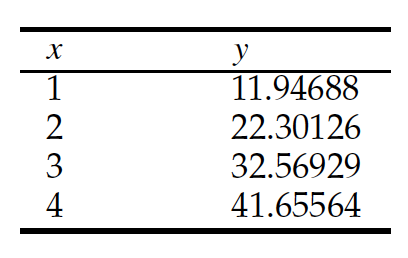

and we want to fit a model 

$$y=a + bx$$

which makes sense because $y$ does look roughly linear in $x$.  Note: $x$ is the *independent variable* and $y$ is the *dependent* variable.

Let's define a vector that contains the unknowns in our linear fit to be

$$ u = (a,b)^T, $$

such that if we evalate our fit at each of the data points we'll have a linear algebra problem of the form:

$$X u = y$$

where 

$$ X = \begin{pmatrix}
1 & 1 \\
1 & 2 \\
1 & 3 \\
1 & 4
\end{pmatrix}$$

and y contains the dependent variables

$$y = (11.94688, 22.30126, 32.56929, 41.65564)^T $$

[Note: that first column in $X$ is all ones because the constant a is the same for each equation in the system...]

Well, this is a bad deal - we have more equations than unknowns, which means there isn't a vector $u$ that can satisfy every equation.  We make the problem *well-posed* by multiplying both sides of the equation by the transpose of the matrix:

$$ \begin{pmatrix}
1 & 1 & 1 & 1 \\
1 & 2 & 3 & 4
\end{pmatrix}
\begin{pmatrix}
1 & 1 \\
1 & 2 \\
1 & 3 \\
1 & 4
\end{pmatrix}
\begin{pmatrix}
a \\
b 
\end{pmatrix} = 
\begin{pmatrix}
1 & 1 & 1 & 1 \\
1 & 2 & 3 & 4
\end{pmatrix} 
\begin{pmatrix}
11.94688 \\
22.30126 \\
32.56929 \\
41.65564
\end{pmatrix}$$

Let's do this with Python, rather than by hand...


In [1]:
import numpy as np
A = np.array([(1,1),(1,2),(1,3),(1,4)])
RHS = np.array([11.94688, 22.30126, 32.56929, 41.65564])
print("The system A x = b has A =\n",A)
print("And b =",RHS)

The system A x = b has A =
 [[1 1]
 [1 2]
 [1 3]
 [1 4]]
And b = [11.94688 22.30126 32.56929 41.65564]


In [2]:
AT_times_A = np.dot(A.transpose(),A)
AT_times_RHS = np.dot(A.transpose(),RHS)
print("The system after multiplying by A transpose is A^T A =\n",AT_times_A)
print("A^T b =",AT_times_RHS)

The system after multiplying by A transpose is A^T A =
 [[ 4 10]
 [10 30]]
A^T b = [108.47307 320.87983]


In [3]:
from GaussElim import *
ab = GaussElimPivotSolve(AT_times_A,AT_times_RHS)
print("The constant a =",ab[0]," with a slope of b =",ab[1])

The constant a = 2.269690000000003  with a slope of b = 9.939430999999999


Here's a plot of the data and the fitted line:

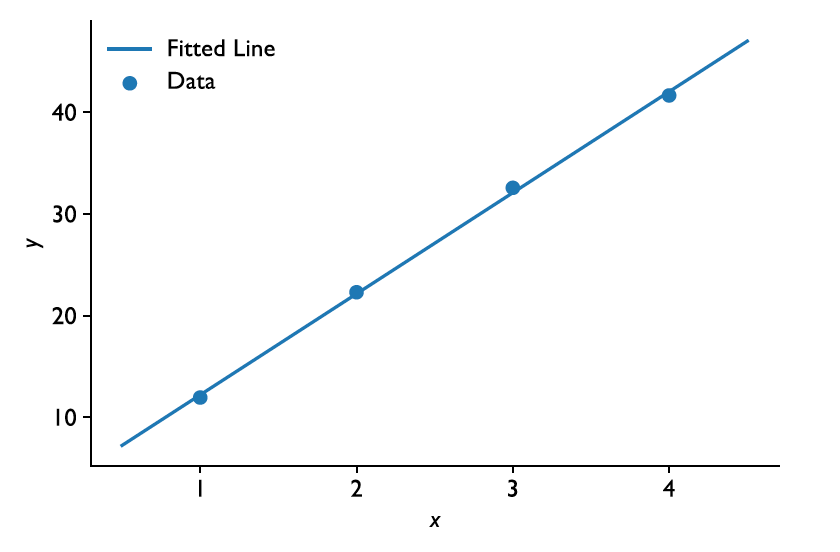

How good is this fit?  Let's look at the $R^2$, which is defined as:

$$ R^2 = 1 - \frac{\sum\limits_{i} (\hat y_i - y_i)^2}{\sum\limits_{i} (\bar y - y_i)^2} $$

where $\hat y_i$ is the $i$th predicted data point by the model 


$$ \hat y_i = {\bf x}_i \cdot {\bf u} = a + b x_i $$

and $\bar y$ is the mean of the data.  

[Notice that in our definition of ${\bf x}_i$ we included a 1 to handle the intercept term: $ {\bf x}_i = (1, x_i)^T $]

We can compute $R^2$ for our data...


In [4]:
yhat = ab[0] + ab[1]*A[:,1]
print("yhat =\t",yhat)
print("y =\t",RHS)
residual = yhat - RHS
print("error =\t",residual)
r2Num = np.sum(residual**2)
r2Denom = np.sum((RHS-RHS.mean())**2)
print("R2 numerator =", r2Num)
print("R2 denominator =", r2Denom)
r2 = 1 - r2Num/r2Denom
print("R2 =", r2)

yhat =	 [12.209121 22.148552 32.087983 42.027414]
y =	 [11.94688 22.30126 32.56929 41.65564]
error =	 [ 0.262241 -0.152708 -0.481307  0.371774]
R2 numerator = 0.46196241067000227
R2 denominator = 494.423405429475
R2 = 0.9990656542437171


A perfect $R^2$ is 1.  Sometimes $R^2$ is called the fraction of variance explained by the model. Therefore, 1 or 100% implies that 100% of the variance in the data is explained by the model. A value of 0.999, as in this fit, is very high and typically only appears in contrived data sets used as examples.

### Least-Squares Regression

Ok, so why did we multiply our system by the transpose of the matrix?  Besides making it solvable, it also means that the linear system minimizes the error:

$$\bar E = \sum\limits_{i=1}^n (\hat y_i - y_i)^2 $$

We can show that our solution gives the minimum, or least, squared error by differentiating the formula for $\hat E$ with respect to ${\bf u}$ and setting the result to 0.  

$$ \frac{\partial \bar E}{\partial {\bf u}} = 2 \sum\limits_{i=1}^n {\bf x}_i^{T} ( {\bf x}_i \cdot {\bf u} - y_i) = 0, $$

which upon rearranging and using the definition of a matrix vector product leads to

$${\bf X}^T {\bf X} {\bf u} = {\bf X}^T {\bf y}.$$

Least-squares regression has the property that if we sum up the errors, we get zero. It
works particularly well when the errors in the data (that is the deviation from the model) are independent random variables that do not depend on the value of the independent or dependent variables.

### Multiple Linear Regression

Let's generalize the problem of fitting a linear function to data to allow for there
to be multiple independent variables. Consider $I$ observations of a dependent variable $y$ and independent variables $x = (1, x_1, x_2, \cdots , x_J )^T$. We desire to fit a linear model of the form

$$ y({\bf x}) = a_0 + a_1 x_1 + \cdots + a_J x_J + \varepsilon.$$

The equations that govern the relationship between $y$ and ${\bf x}$ are

$$ {\bf X}{\bf u} = {\bf y}$$

where ${\bf X}$ is an $I \times (J+1)$ matrix of the form

$$\begin{pmatrix}
1 & x_{11} & x_{12} & \cdots & x_{1J} \\
1 & x_{21} & x_{22} & \cdots & x_{2J} \\
\vdots & \vdots  & \vdots & \vdots & \vdots \\
1 & x_{i1} & x_{i2} & \cdots & x_{iJ} \\
\vdots & \vdots  & \vdots & \vdots & \vdots \\
1 & x_{I1} & x_{I2} & \cdots & x_{IJ} 
\end{pmatrix}$$

where the notation $x_{ij}$ is the $i$th observation for the $j$th independent variable.  The vector ${\bf u}$ holds the coefficients of the model

$$ {\bf u} = (a_0, a_1, \cdots, a_J)^T $$,

and the vector ${\bf y}$ contains the observations of the dependent variable

$$ {\bf y} = (y_0, y_1, \cdots, y_I)^T $$.

As before, we will multiply both sides of the equation by ${\bf X}^T$ to form the normal equations, and solve for ${\bf u}$. We will now apply this more general technique to a real set of data.



In [5]:
import csv
with open('FootballScores.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    opponent = []
    Yards = np.array([])
    Points = np.array([])
    OffTurn = np.array([])
    DefTurn = np.array([])
    for row in reader:
        #print(row)
        opponent.append(row['Opponent'])
        Yards = np.append(Yards,float(row['Yards Gained']))
        Points = np.append(Points,float(row['Points Scored']))
        OffTurn = np.append(OffTurn,float(row['Off Turnovers']))
        DefTurn = np.append(DefTurn,float(row['Def Turnovers']))
print(opponent)
print(Yards)
print(Points)
print(OffTurn)
print(DefTurn)

['Rice', 'Sam Houston State', 'Alabama', 'SMU ', 'Arkansas ', 'Ole Miss ', 'Auburn', 'Vanderbilt', 'UTEP ', 'Mississippi State', 'LSU ', 'Missouri ', 'Duke ']
[486. 714. 628. 581. 523. 587. 602. 558. 564. 537. 299. 379. 541.]
[52. 65. 42. 42. 45. 41. 41. 56. 57. 51. 10. 21. 52.]
[1. 1. 2. 1. 0. 2. 2. 5. 1. 3. 2. 1. 0.]
[2. 2. 1. 3. 2. 1. 1. 3. 4. 1. 0. 0. 2.]


Now we want to perform our least squares procedure where the independent variable is
yards gained and the dependent variable is points scored. First, we build the matrix as before.

This is a good opportunity to use the vstack function in NumPy to stack two vectors on top of each other and then take the transpose to get a rectangular matrix with 13 rows and 2 columns:

In [6]:
A = np.vstack([np.ones(Yards.size), Yards]).transpose()
print("The A matrix is\n",A)

The A matrix is
 [[  1. 486.]
 [  1. 714.]
 [  1. 628.]
 [  1. 581.]
 [  1. 523.]
 [  1. 587.]
 [  1. 602.]
 [  1. 558.]
 [  1. 564.]
 [  1. 537.]
 [  1. 299.]
 [  1. 379.]
 [  1. 541.]]


NumPy also has a built-in least squares function linalg.lstsq. This function is used by
passing it the data matrix and the righthand side.We use this function to determine the linear model for points scored as a function of yards gained:

In [7]:
solution = np.linalg.lstsq(A,Points)[0]
print("The function is Points =",solution[0],"+",solution[1],"* Yards")

The function is Points = -16.2577502382346 + 0.11235187213845545 * Yards


<ipython-input-7-aeee804bfe63>:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  solution = np.linalg.lstsq(A,Points)[0]


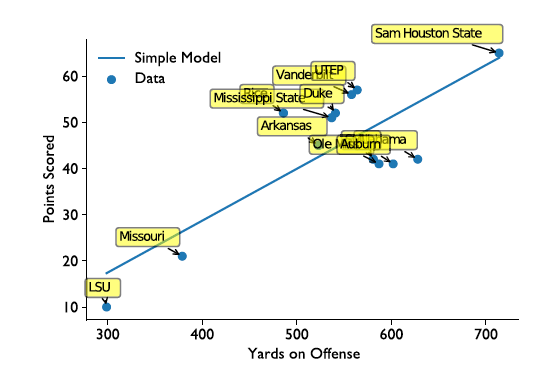

This is what real data typically look like: a lot messier than a simple line with a little noise.
The model shows that several games with very high or very low yards set the trend for the
line. Also we notice that half of the data are on one side of the line and the other half are on
the other. This splitting of the data is typical of least-squares regression.

To adjust our model, we can remove two of the lower conference schools (Sam Houston
State and UTEP); the scores in these games are expected to be different than the other games
based on the strength of those teams. This removes two data points to the top right. Removing
data points like this can help a model if we think that the data removed is not representative
of the overall data set.

In [8]:
Asmall = A[(0,2,3,4,5,6,7,9,10,11,12),:]
PointsSmall = Points[[0,2,3,4,5,6,7,9,10,11,12]]
solution = np.linalg.lstsq(Asmall,PointsSmall)[0]
print("The function is Points =",solution[0],"+",solution[1],"* Yards")

The function is Points = -13.900235706492904 + 0.10590851123429854 * Yards


<ipython-input-8-3725a02b317e>:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  solution = np.linalg.lstsq(Asmall,PointsSmall)[0]


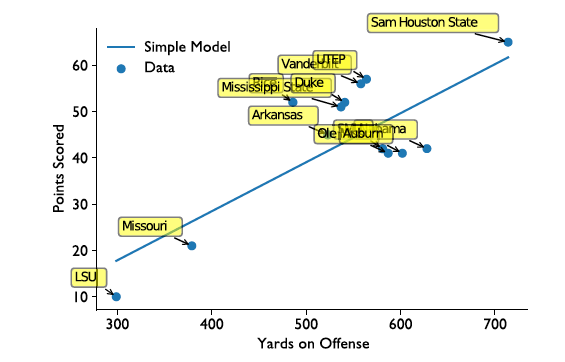

Notice that the slope of our line did not change much by removing some data (0.112 points
per yard versus 0.106). This is a useful observation. It means that our model is robust to
removing some games. Had the result changed drastically we should be worried that the
model was driven by just a few data points.

To attempt to improve this model we could add more independent variables. For example,
the number of turnovers produced by the defense (i.e., interceptions or fumbles that the
opponent gives up) or given up by the offense (throwing an interception or losing a fumble
by the offense) could also be important. The next figure colors the dots with the number of
turnovers taken by the defense, and the size of the dot is the number of turnovers given up
by the offense. Looking at this chart seems to indicate that the lower scoring games had fewer
turnovers produced by the defense.

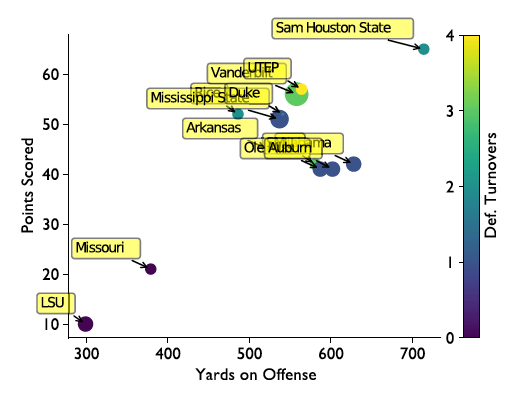

In [9]:
A = np.vstack([np.ones(Yards.size), Yards, OffTurn, DefTurn]).transpose()
print("The A matrix is\n",A)
solution = np.linalg.lstsq(A,Points)[0]
print("The function is Points =",solution[0],
      "+",solution[1],"* Yards","+",solution[2],
      "* Off Turnovers","+",solution[3],"* Def Turnovers")

The A matrix is
 [[  1. 486.   1.   2.]
 [  1. 714.   1.   2.]
 [  1. 628.   2.   1.]
 [  1. 581.   1.   3.]
 [  1. 523.   0.   2.]
 [  1. 587.   2.   1.]
 [  1. 602.   2.   1.]
 [  1. 558.   5.   3.]
 [  1. 564.   1.   4.]
 [  1. 537.   3.   1.]
 [  1. 299.   2.   0.]
 [  1. 379.   1.   0.]
 [  1. 541.   0.   2.]]
The function is Points = -10.294646698915217 + 0.08263563380258453 * Yards + 0.37696192259278427 * Off Turnovers + 5.570336623961822 * Def Turnovers


<ipython-input-9-d874a27a07a8>:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  solution = np.linalg.lstsq(A,Points)[0]


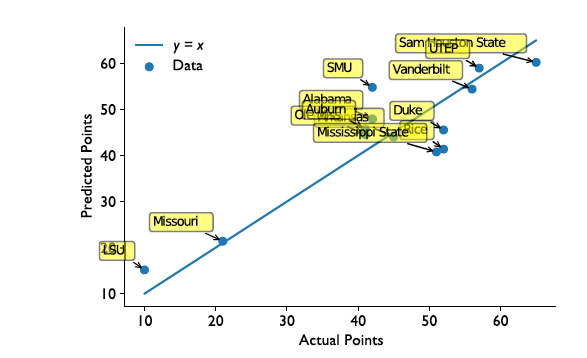

This figure indicates that our model does seem to predict the number of points scored
based on the independent variables. To get a more quantitative measure of the model accuracy
we will compute the average amount by which the model is in error. This quantity is the average
absolute value of the error, which is simply called the mean absolute error. For this model the
mean absolute error is

In [10]:
yhat = np.dot(A,solution)
np.mean(np.fabs(Points-yhat))

5.320173467252322

We have to compute the average absolute error because of error cancellation—if we computed
the average error, the cancellation of positive and negative errors would give us an
average error very close to zero. Indeed this is what we see:

In [11]:
np.mean(Points-yhat)

1.3664283380001927e-14

As indicated above, we should remove offensive turnovers from the model because the
coefficient for this variable did not make sense.We will remove this variable, refit the model,
and plot the actual versus predicted values.

In [12]:
A = np.vstack([np.ones(Yards.size), Yards, DefTurn]).transpose()
solution = np.linalg.lstsq(A,Points)[0]
print("The function is Points =",solution[0],
      "+",solution[1],"* Yards","+",solution[2],"* Def Turnovers")

The function is Points = -9.790279844475215 + 0.0829036035041299 * Yards + 5.546878047855064 * Def Turnovers


<ipython-input-12-69acdf3f4763>:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  solution = np.linalg.lstsq(A,Points)[0]


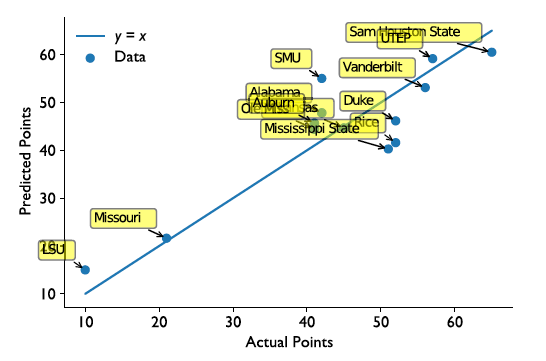

The coefficients of thismodel indicate that an additional defensive turnover is worth about
5.5 points on offense and that each 10 yards gained is worth 0.8 points. The actual versus predicted
values plot looks very similar to the previous model. Additionally, the mean absolute
error is about the same.


In [13]:
np.mean(np.fabs(Points-yhat))

5.320173467252322

We want to compute the $R^2$...

In [14]:
1-np.sum((Points-yhat)**2)/np.sum((Points.mean() - Points)**2)

0.7918429217236838

This is a respectable value for $R^2$ for a real data set: almost 80% of the variability in points
scored can be explained by our model that contains only the number yards gained and the
number of defensive turnovers. The mean absolute error also tells us that given the number
of yards gained by the Aggies and the number of takeaways on defense, we can estimate how
many points the team scored to within about ±5 points.

It is a good thing to remove unnecessary variables in the model for several reasons. The
first is that putting too many variables in the model can lead to overfitting: if we add enough
variables eventually the model will have zero error (when we have the same number of variables
as observations, the fit will be “perfect”). However, this model will perform poorly in
making predictions.

The other reason is that strange values will call the model into question. Nobody will
believe anything else you say if you make a patently false claim (like turn the ball over to get
more points). It is important when performing curve fitting to think critically about what the
model is indicating. Especially, if you want to use the model to explain what is occurring in
the data set.

### "Nonlinear Models"

Least squares regression can be applied to models that are nonlinear in the independent
variables, if we can map the nonlinearity to new independent variables. In this section we
will demonstrate this procedure.

Suppose we wish to fit a model that has the form

$$ f(x) = a_0 + a_1 x_1 + a_2 x_1^2 .$$

We can fit this model using least squares by defining a new variable $x_2 \equiv x_1^2$ . This will make
the model look like a multivariate regression model:

$$ f(x) = a_0 + a_1 x_1 + a_2 x_2 .$$

Therefore, to fit this quadratic model we set up the matrix with this additional variable x2 in
the appropriate column.

Consider the following data generated from the function $y = 1− 5x+ 2x^2$ with noise added:

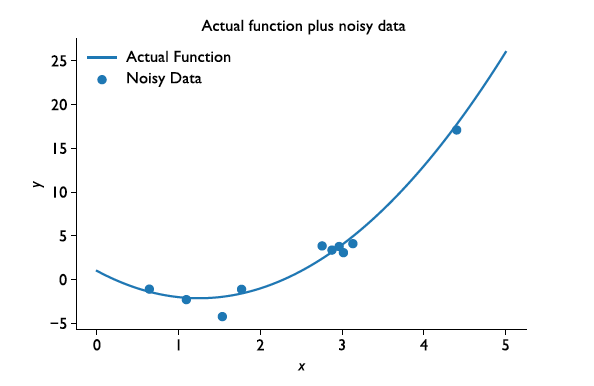

To fit the quadratic model need to build the matrix with x2 in the appropriate column
before calling the least squares function:
    

In [22]:
#now build the matrix
A = np.ones((N,3))
for i in range(N):
    A[i,1] = x[i]
    A[i,2] = x[i]**2
solution = np.linalg.lstsq(A,y)[0]
print("The function is y =",solution[0],"+",
      solution[1],"* x","+",solution[2],"* x^2")

NameError: name 'N' is not defined

How well do we do?

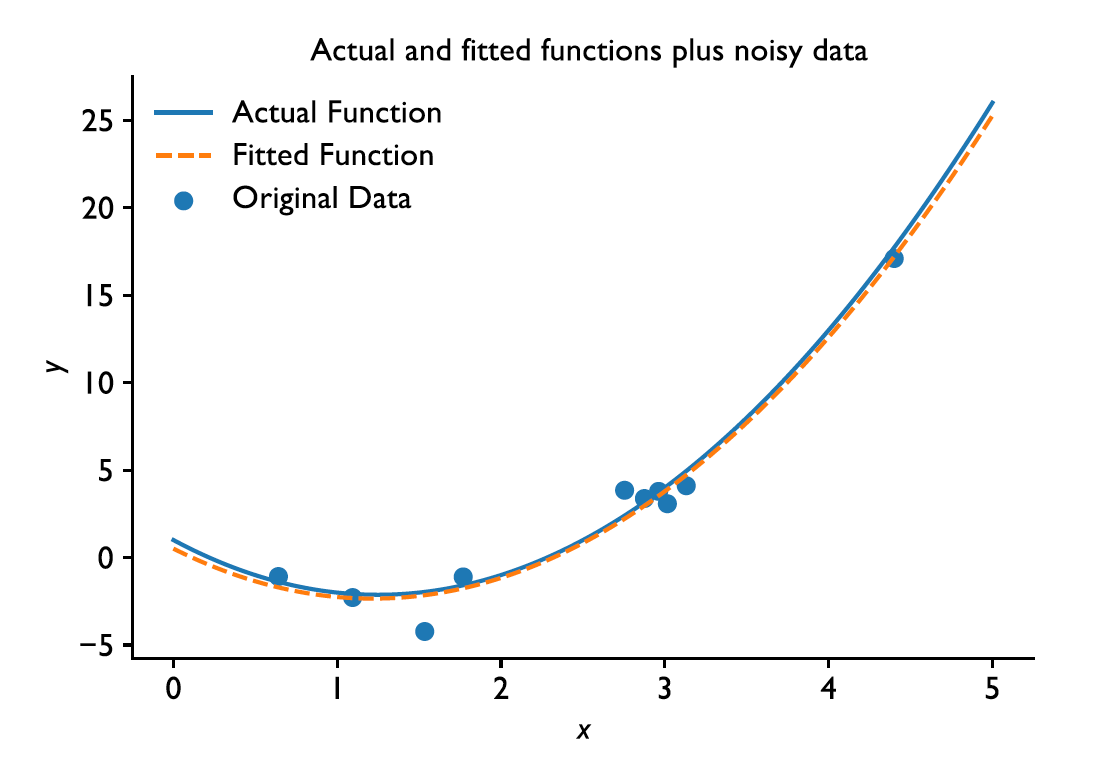

If we wanted to fit more complicated polynomial models, we can do this by placing the
correct powers of the independent variables in the data matrix X. This makes the least squares
curve fitting process very flexible.

We can also fit non-polynomial models such as

$$ f(x) = a + b x + c \sin{(x)}.$$

In this case we have a column in the matrix that correspond to sin x.We will demonstrate this
with data produced from the function $y = 1− 0.5x +3 \sin{(x)} $ with added noise:

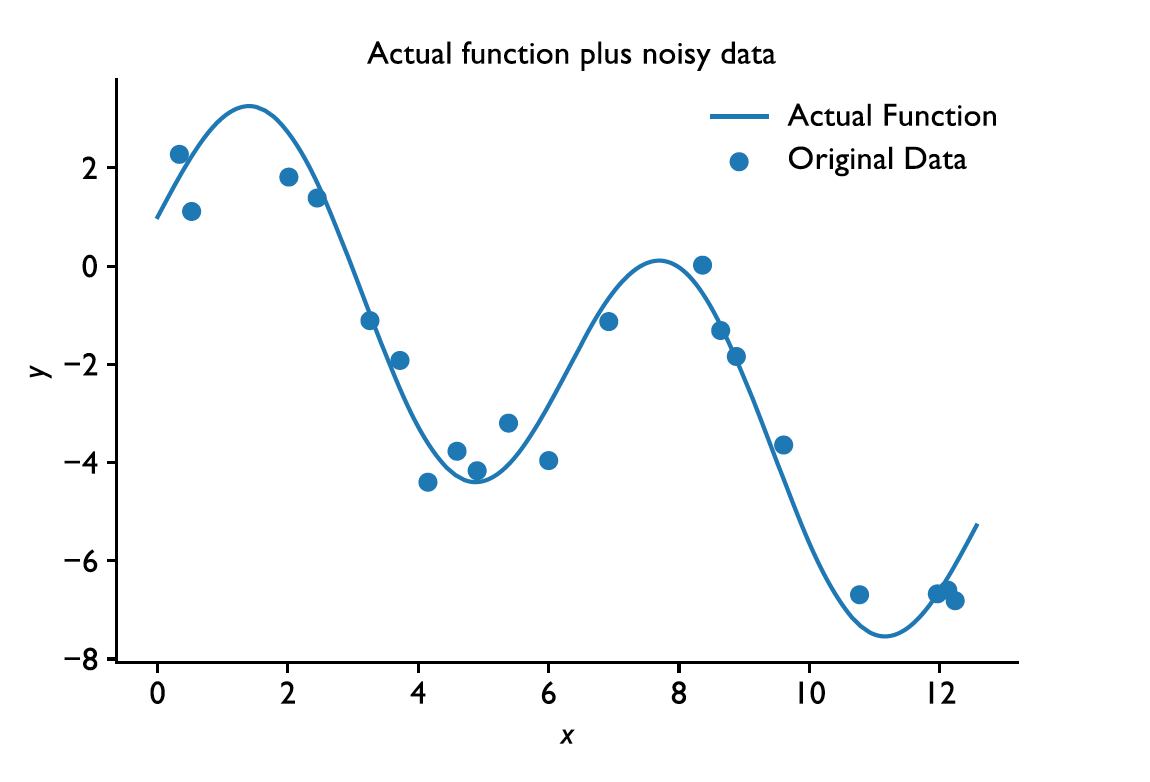

To fit this model we place the sine of x in the appropriate column of the data matrix and
solve using least squares, as shown next:

In [ ]:
#now build the matrix
A = np.ones((N,3))
for i in range(N):
    A[i,1] = x[i]
    A[i,2] = np.sin(x[i])
solution = np.linalg.lstsq(A,y)[0]
print("The fitted function is y =",solution[0],
      "+",solution[1],"* x","+",solution[2],"* sin(x)")

The fitted function does deviate from the original function, primarily due to the noise in
the data making some of the points used to fit the model being far away from the actual
function. Despite this, the overall trend appears to be correct. This is apparent in a graphical
comparison between the original function and the fitted function.

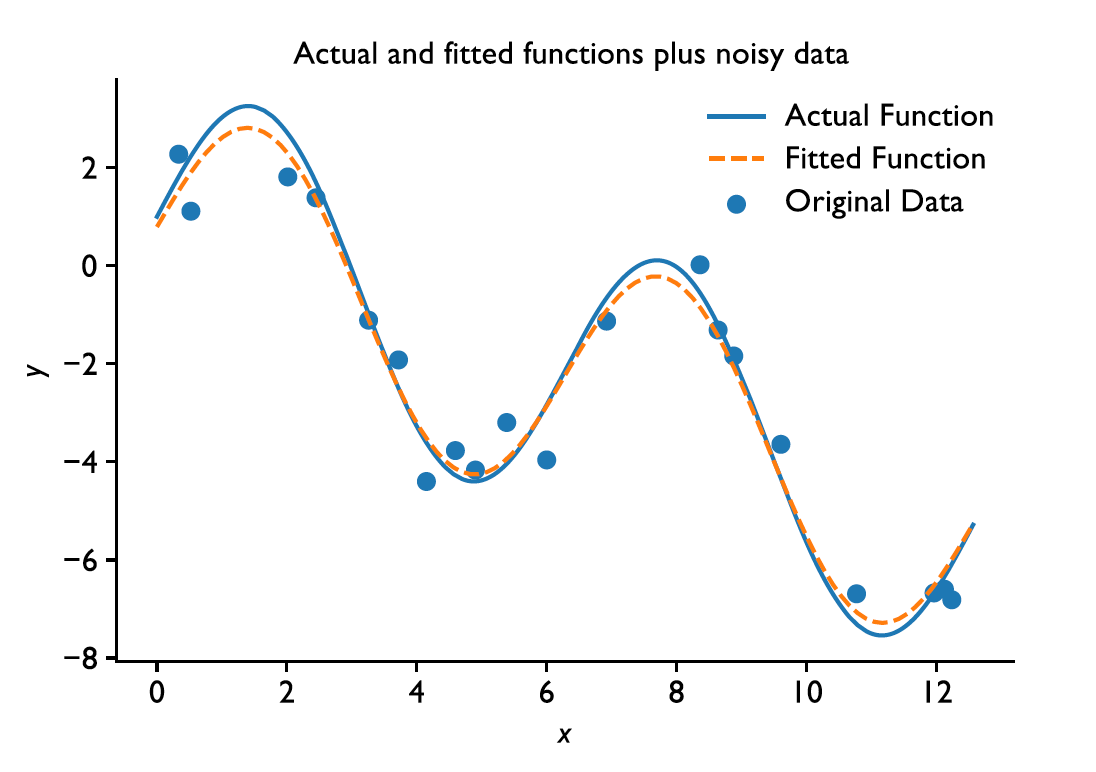

In this example with the sine function, the least squares regression model does a good job
of finding the underlying model coefficients. Despite there being some data points far away
from the actual function due to noise, the model fit is very close to the actual model used to
generate the data.

### Exponential models - The Logarithmic Transform

Beyond nonlinear transformations to independent variables, we can use logarithms to fit
models that are exponentials or power laws of independent variables. A particularly relevant
example would be fitting a model to determine the half-life of a radioactive sample:

$$ A(t) = A_0 e^{-\lambda t} $$

$$\lambda = \frac{\ln{(2)}}{t_{1/2}} $$

where $A$ is the activity. To fit this model we can take the natural logarithm of both sides and
find

$$ \ln{A(t)} = \ln{A_0} - \lambda t $$

Therefore, if we fit a model where the dependent variable (i.e., the left-hand side) is the natural
logarithm of $f(x)$  then we can infer both the half-life and the initial activity.
As before we will generate data from a known exponential and add noise to the data
points. In this case we generate decay data from a sample of 1012 atoms of arsenic-76, which
has a half-life 1.09379±0.00045 days.

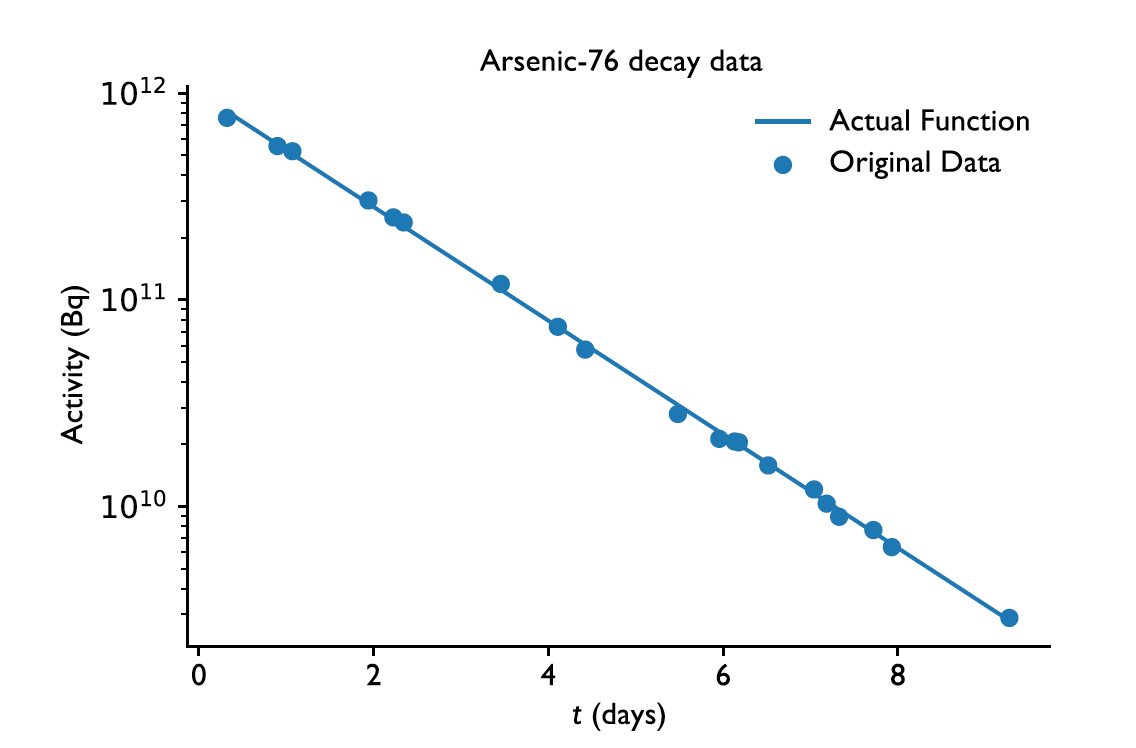

To fit the exponentialmodel, we need to make the righthand side in the least-squares equations
equal to the natural logarithm. The data matrix will contain the number of days since
the sample was obtained.

In [ ]:
#now build the matrix
A = np.ones((N,2))
for i in range(N):
    A[i,1] = t[i]
print("The A matrix is\n",A)
solution = np.linalg.lstsq(A,np.log(activity))[0]
print("The inital activity is A_0 =",np.exp(solution[0]),
      "and the half-life is",-np.log(2)/solution[1],"days.")

The fitted model gives a reasonable approximation of the half-life given the noise in the data.

### Power law models

It is also possible fit power-law models using similar manipulations. The function

$$f(x) = a x^b,$$

can be transformed to a linear, additive model by writing a function

$$\ln{f(x)} = \ln{a} + b \ln{(x)},$$

that is we take the natural logarithm of $x$ and $f(x)$ to get a linear function. Such power laws
appear in all kinds of natural data. One, perhaps unexpected, place a power law appears is
in the number of words used with a given frequency in language. In English it has been conjectured
that the 100 most common words make up 50% of all writing. Another way to look
at this, is that there are a small number of words that are used very frequently (e.g., the, a,
and, etc.), and many words that are used very infrequently (e.g. consanguine or antiderivative).
Therefore, if we look at any work of literature we expect there to be thousands of words
used one or two times, and a few words used thousands of times. To demonstrate this we can
look at the word frequency distribution for that venerable work of literature Moby Dick. The
next figure is a histogram of word frequency in Moby Dick. For example, there are approximately
104 words that are only used once in the book out of the 17,227 unique words in the
book.

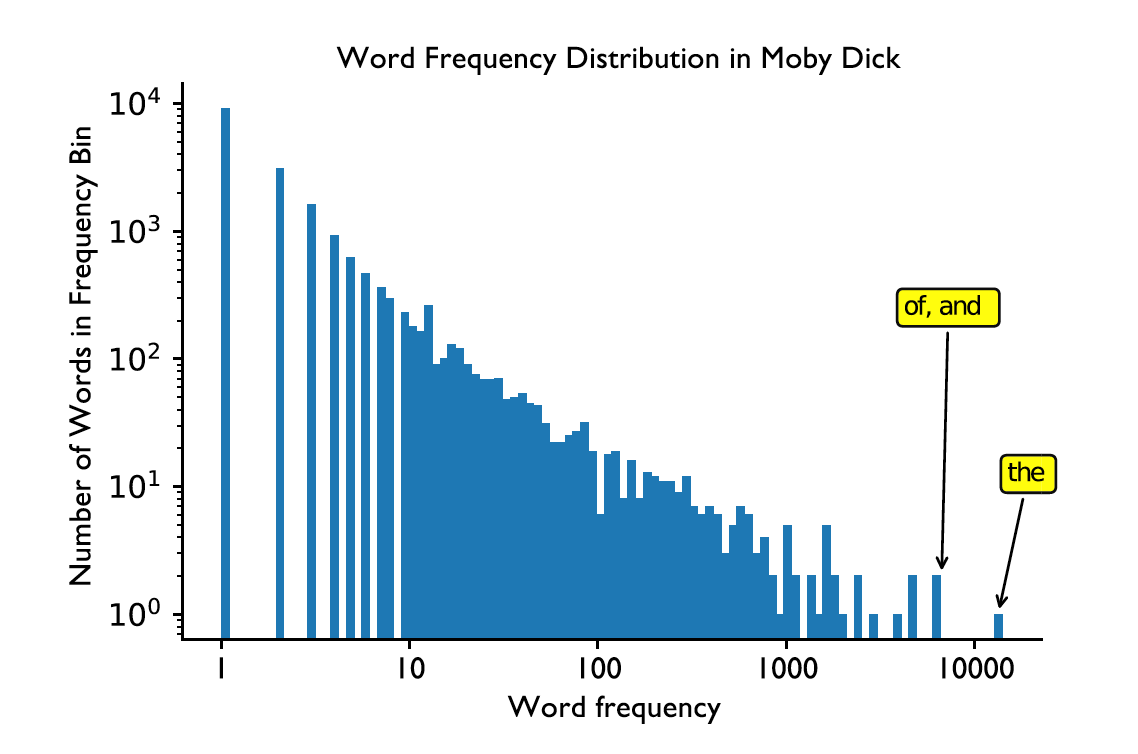

The word “the” was used over 10,000 times.
For this data, we want to fit a model as

$$ \texttt{Number of words with a given frequency} = a \; (\texttt{Word Frequency})^b.$$

This will require us to make the righthand side of the least square equations equal to the
logarithm of the dependent variable, and place the logarithm of the independent variable in
the data matrix. The resulting model for Moby Dick is

$$\texttt{Number of words with a given frequency} = 7.52 \; \texttt{(Word Frequency)}^{−0.94}. $$

We can then compare this model to the actual data, and see that a simple power law is a
reasonable fit to the data:

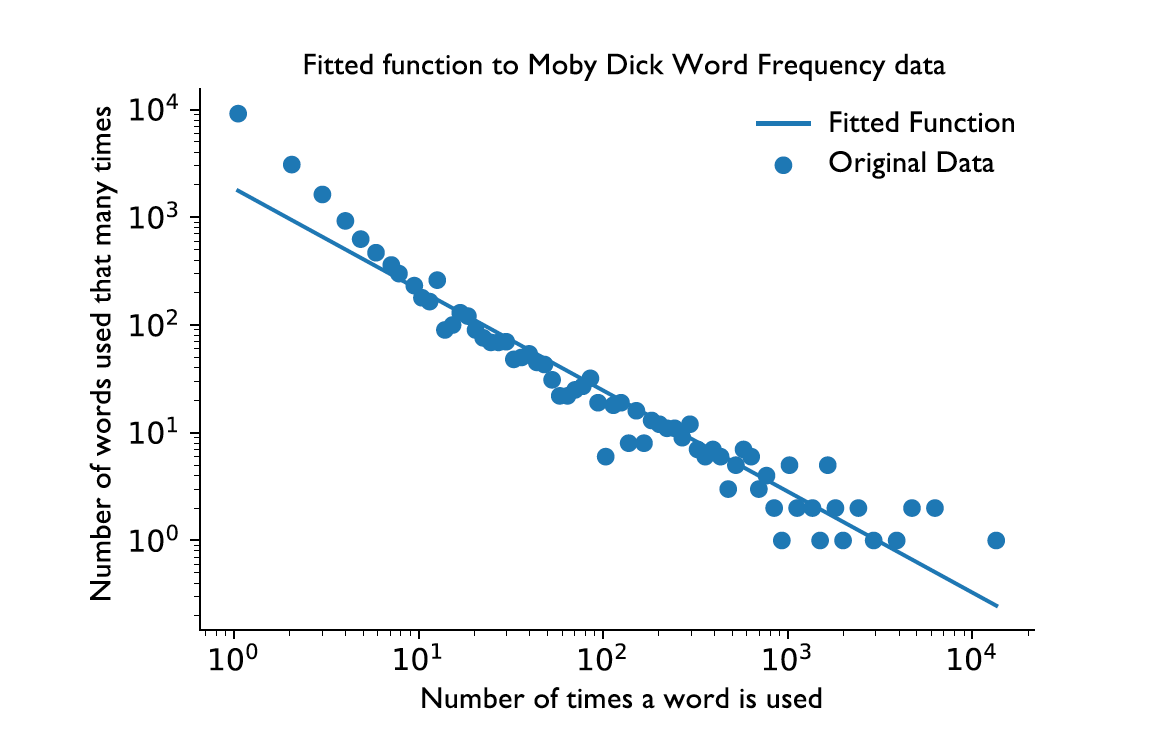

Except for words used less than 3 times, the model predicts the number of words with a
given frequency well. This natural behavior of language (and other systems such as income)
are examples of power laws.